In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

correct_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
print(os.listdir(correct_path))

['train', 'val', 'test']


In [7]:
print("Train folders:", os.listdir(correct_path + '/train'))
print("Val folders:", os.listdir(correct_path + '/val'))
print("Test folders:", os.listdir(correct_path + '/test'))

Train folders: ['PNEUMONIA', 'NORMAL']
Val folders: ['PNEUMONIA', 'NORMAL']
Test folders: ['PNEUMONIA', 'NORMAL']


In [8]:
import os

base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'

splits = ['train', 'val', 'test']
classes = ['PNEUMONIA', 'NORMAL']

for split in splits:
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{split.capitalize()} - {cls}: {count} images")


Train - PNEUMONIA: 3818 images
Train - NORMAL: 1403 images
Val - PNEUMONIA: 1135 images
Val - NORMAL: 418 images
Test - PNEUMONIA: 1141 images
Test - NORMAL: 415 images


In [9]:
import os
import pickle
import pandas as pd
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# ------------------ CONFIG ------------------ #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
checkpoint_path = '/content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5'
final_model_path = '/content/drive/MyDrive/TEfficientNetV2B0_final.h5'
history_path = '/content/drive/MyDrive/TEfficientNetV2B0_history.pkl'
csv_log_path = '/content/drive/MyDrive/TEfficientNetV2B0_training_log.csv'

epochs = 15
batch_size = 32
input_shape = (224, 224, 3)

# ------------- DYNAMIC EPOCH RESUME ---------------- #
start_epoch = 0
if os.path.exists(csv_log_path):
    try:
        df = pd.read_csv(csv_log_path)
        start_epoch = int(df['epoch'].iloc[-1]) + 1
        print(f"🔁 Resuming from epoch {start_epoch}")
    except Exception as e:
        print(f"⚠️ Could not read CSV log: {e}")

# --------------- DATASET ------------------- #
train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'val'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

# ------------- LOAD OR CREATE MODEL -------------- #
if os.path.exists(checkpoint_path):
    print("📦 Loading model from checkpoint...")
    model = load_model(checkpoint_path)

    # ✅ Recompile to fix training error
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
else:
    print("🛠 Building new model...")
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# ------------- CALLBACKS ----------------- #
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

csv_logger = CSVLogger(csv_log_path, append=True)

# ------------- TRAIN --------------------- #
history = model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=start_epoch,
    epochs=epochs,
    callbacks=[checkpoint_callback, csv_logger]
)

# ------------- SAVE HISTORY -------------- #
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

# ------------- FINAL MODEL SAVE ---------- #
model.save(final_model_path)
print("✅ Final model saved:", final_model_path)


Found 5221 images belonging to 2 classes.
Found 1553 images belonging to 2 classes.
🛠 Building new model...
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7327 - loss: 0.5022
Epoch 1: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1946s 12s/step - accuracy: 0.7332 - loss: 0.5016 - val_accuracy: 0.9156 - val_loss: 0.2408
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8837 - loss: 0.2701
Epoch 2: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.8837 - loss: 0.2700 - val_accuracy: 0.9356 - val_loss: 0.1849
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9065 - loss: 0.2324
Epoch 3: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.9064 - loss: 0.2324 - val_accuracy: 0.9408 - val_loss: 0.1685
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9187 - loss: 0.2029
Epoch 4: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - accuracy: 0.9187 - loss: 0.2029 - val_accuracy: 0.9453 - val_loss: 0.1503
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9063 - loss: 0.2166
Epoch 5: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.9063 - loss: 0.2165 - val_accuracy: 0.9524 - val_loss: 0.1315
Epoch 6/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9270 - loss: 0.1835
Epoch 6: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.9270 - loss: 0.1836 - val_accuracy: 0.9536 - val_loss: 0.1320
Epoch 7/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9179 - loss: 0.1938
Epoch 7: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.9180 - loss: 0.1938 - val_accuracy: 0.9588 - val_loss: 0.1296
Epoch 8/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9287 - loss: 0.1870
Epoch 8: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.9287 - loss: 0.1870 - val_accuracy: 0.9594 - val_loss: 0.1207
Epoch 9/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9273 - loss: 0.1730
Epoch 9: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.9273 - loss: 0.1731 - val_accuracy: 0.9594 - val_loss: 0.1152
Epoch 10/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9269 - loss: 0.1770
Epoch 10: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.9269 - loss: 0.1770 - val_accuracy: 0.9620 - val_loss: 0.1144
Epoch 11/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9240 - loss: 0.1956
Epoch 11: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.9240 - loss: 0.1955 - val_accuracy: 0.9607 - val_loss: 0.1129
Epoch 12/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9278 - loss: 0.1784
Epoch 12: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.9278 - loss: 0.1784 - val_accuracy: 0.9614 - val_loss: 0.1100
Epoch 13/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9309 - loss: 0.1722
Epoch 13: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.9309 - loss: 0.1722 - val_accuracy: 0.9614 - val_loss: 0.1080
Epoch 14/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9332 - loss: 0.1679
Epoch 14: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.9332 - loss: 0.1679 - val_accuracy: 0.9543 - val_loss: 0.1248
Epoch 15/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9401 - loss: 0.1583
Epoch 15: saving model to /content/drive/MyDrive/TEfficientNetV2B0_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.9401 - loss: 0.1583 - val_accuracy: 0.9639 - val_loss: 0.1037


✅ Final model saved: /content/drive/MyDrive/TEfficientNetV2B0_final.h5


In [3]:
import pickle

# ✅ Load training history for EfficientNetV2B0
with open('/content/drive/MyDrive/TEfficientNetV2B0_history.pkl', 'rb') as f:
    history = pickle.load(f)

# ✅ Extract final epoch's training and validation accuracy
final_train_acc = history['accuracy'][-1]
final_val_acc = history['val_accuracy'][-1]

print(f"✅ Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"✅ Final Validation Accuracy: {final_val_acc * 100:.2f}%")


✅ Final Training Accuracy: 93.76%
✅ Final Validation Accuracy: 96.39%


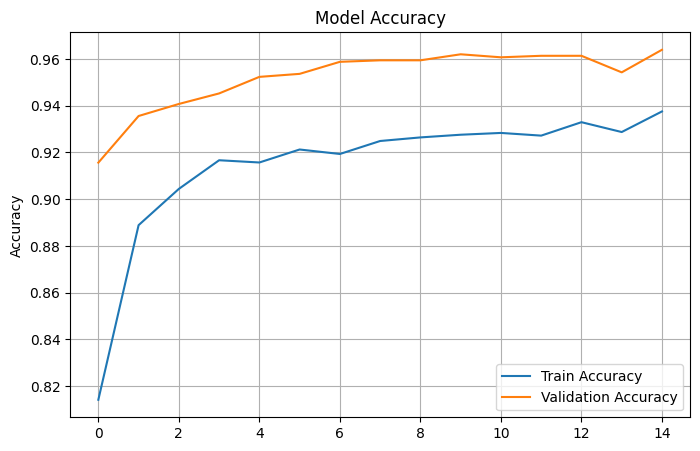

In [4]:
import matplotlib.pyplot as plt
import pickle

# Load history
with open('/content/drive/MyDrive/TEfficientNetV2B0_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')        # Updated title
plt.xlabel('')                     # No x-axis label
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


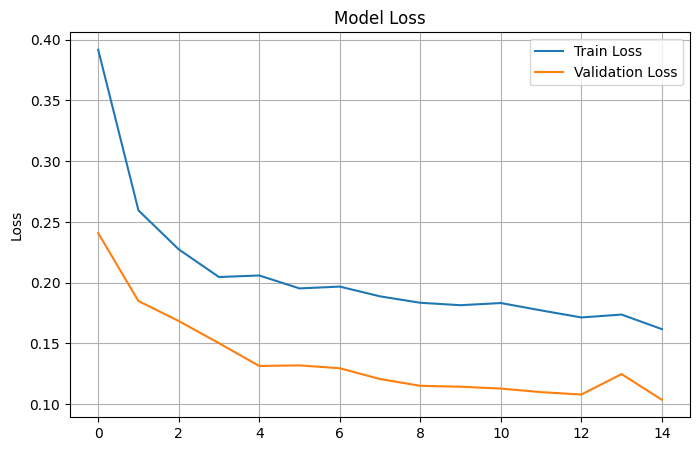

In [5]:
import matplotlib.pyplot as plt
import pickle

# Load history
with open('/content/drive/MyDrive/TEfficientNetV2B0_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')        # Title for loss
plt.xlabel('')                 # No x-axis label
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess

# -------- CONFIG -------- #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
final_model_path = '/content/drive/MyDrive/TEfficientNetV2B0_final.h5'
batch_size = 32
input_shape = (224, 224, 3)

# -------- LOAD MODEL -------- #
model = load_model(final_model_path)

# -------- DATASET PREP -------- #
val_test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# -------- EVALUATE -------- #
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


Found 1556 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 504s 10s/step - accuracy: 0.9445 - loss: 0.1550
✅ Test Accuracy: 95.82%
📉 Test Loss: 0.1151


49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step
📊 Overall Model Performance (Threshold = 0.50):

✅ Accuracy :  0.9582
🎯 Precision: 0.9728
🔁 Recall   : 0.9702
📈 F1 Score : 0.9715


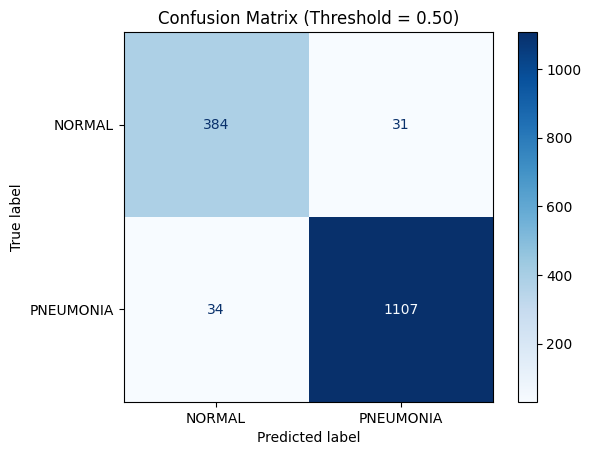


🧮 Confusion Matrix Breakdown:
✅ True Positives (TP): 1107
✅ True Negatives (TN): 384
❌ False Positives (FP): 31
❌ False Negatives (FN): 34


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# -------- Step 1: True labels from generator -------- #
y_true = test_generator.classes

# -------- Step 2: Model predictions -------- #
y_pred_probs = model.predict(test_generator, verbose=1)

# -------- Step 3: Apply threshold (e.g. 0.5) -------- #
threshold = 0.50
y_pred = (y_pred_probs > threshold).astype(int).reshape(-1)

# -------- Step 4: Metrics -------- #
overall_accuracy  = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred)
overall_recall    = recall_score(y_true, y_pred)
overall_f1        = f1_score(y_true, y_pred)

# -------- Step 5: Print metrics -------- #
print("📊 Overall Model Performance (Threshold = 0.50):\n")
print(f"✅ Accuracy :  {overall_accuracy:.4f}")
print(f"🎯 Precision: {overall_precision:.4f}")
print(f"🔁 Recall   : {overall_recall:.4f}")
print(f"📈 F1 Score : {overall_f1:.4f}")

# -------- Step 6: Confusion Matrix -------- #
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())  # e.g. ['NORMAL', 'PNEUMONIA']

# -------- Step 7: Plot Confusion Matrix -------- #
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Threshold = 0.50)")
plt.grid(False)
plt.show()

# -------- Step 8: TP, TN, FP, FN Breakdown -------- #
tn, fp, fn, tp = cm.ravel()

print("\n🧮 Confusion Matrix Breakdown:")
print(f"✅ True Positives (TP): {tp}")
print(f"✅ True Negatives (TN): {tn}")
print(f"❌ False Positives (FP): {fp}")
print(f"❌ False Negatives (FN): {fn}")
